# Entregable 3.1 - Clústering

Francisco Javier Mercader Martínez

## Machine Learning I. Grado en Ciencia de datos

Los siguientes ejercicios tienen que ser entregados dentro de las dos horas de prácticas. Como realizar el entregable:


-   La realización se debe de hacer de forma  **INDIVIDUAL**
-   Se debe de enviar un notebook con el código y las explicaciones, comentarios, análisis y justificaciones en Markdown.
-   Reproducibilidad:
    -   Se debe de establecer una variable semilla con un número al inicio, esta variables será la que se utilice para el np.random_seed y para el random_state.
    -   Las bases de datos se cargan con rutas relativas.
-   El notebook se debe de subir a la tarea del aula virtual creada antes de la finalización de la hora de clase. (Ver tarea y fecha de cierre).

**DATASET** 
El dataset "Mall_customers.csv"  es un conjunto de datos que recogen información de clientes sobre su gasto anual en una gran superficie. El separador entre atributos es el ','.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from scipy.cluster import vq, hierarchy
from sklearn.cluster import KMeans,DBSCAN
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
random_seed = 1234

np.random.seed(random_seed)

### EJERCICIO


1. Carga el dataset "Mall_customers.csv", ¿cuántas características tiene?. Realiza el resto de apartados a partir de este conjunto de datos.

    Analiza los datos y realiza las operaciones oportunas para que estén preparados para aplicar técnicas de clústering. Justifica las transformaciones realizadas.

In [3]:
df = pd.read_csv('Mall_customers.csv', index_col=0)

df

,Annual Income (k$),Spending Score (1-100),Gender_Male
Age,,,
19,15,39,1
21,15,81,1
20,16,6,0
23,16,77,0
31,17,40,0
...,...,...,...
35,120,79,0
45,126,28,0
32,126,74,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 19 to 30
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Annual Income (k$)      200 non-null    int64
 1   Spending Score (1-100)  200 non-null    int64
 2   Gender_Male             200 non-null    int64
dtypes: int64(3)
memory usage: 6.2 KB


El dataset presenta 3 características. Vamos a comprobar cómo están distribuidos los datos, para ver si es necesario una estandarización de los mismos. Para ello podemos realizar un gráfico de barras.

<AxesSubplot:>

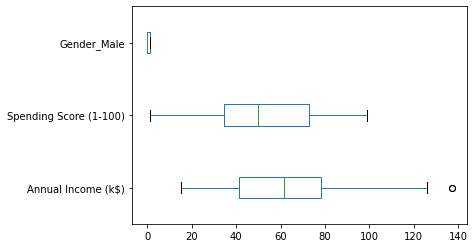

In [5]:
df.boxplot(grid=False, vert=False)

Como se puede apreciar es necesario que transformar los datos para que estos estén en la misma escala y los podamos comparar.

<AxesSubplot:>

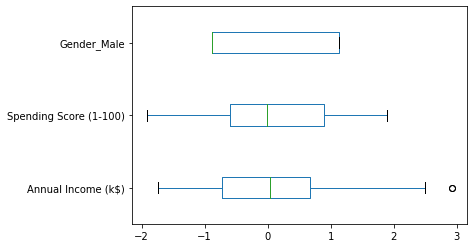

In [6]:
scaler = StandardScaler()
scaler.fit(df)
data_scaled = scaler.transform(df)

df_scaled = pd.DataFrame(data_scaled, columns=df.columns, index=df.index)
df_scaled.boxplot(grid=False, vert=False)

2. Aplica el clustering jerárquico de la librería `Scipy`, muestra el dendograma. ¿Según el dendograma, cuáles podrían ser el número de clústeres óptimos? Justifica tu respuesta. ¿Qué parámetros le has puesto?

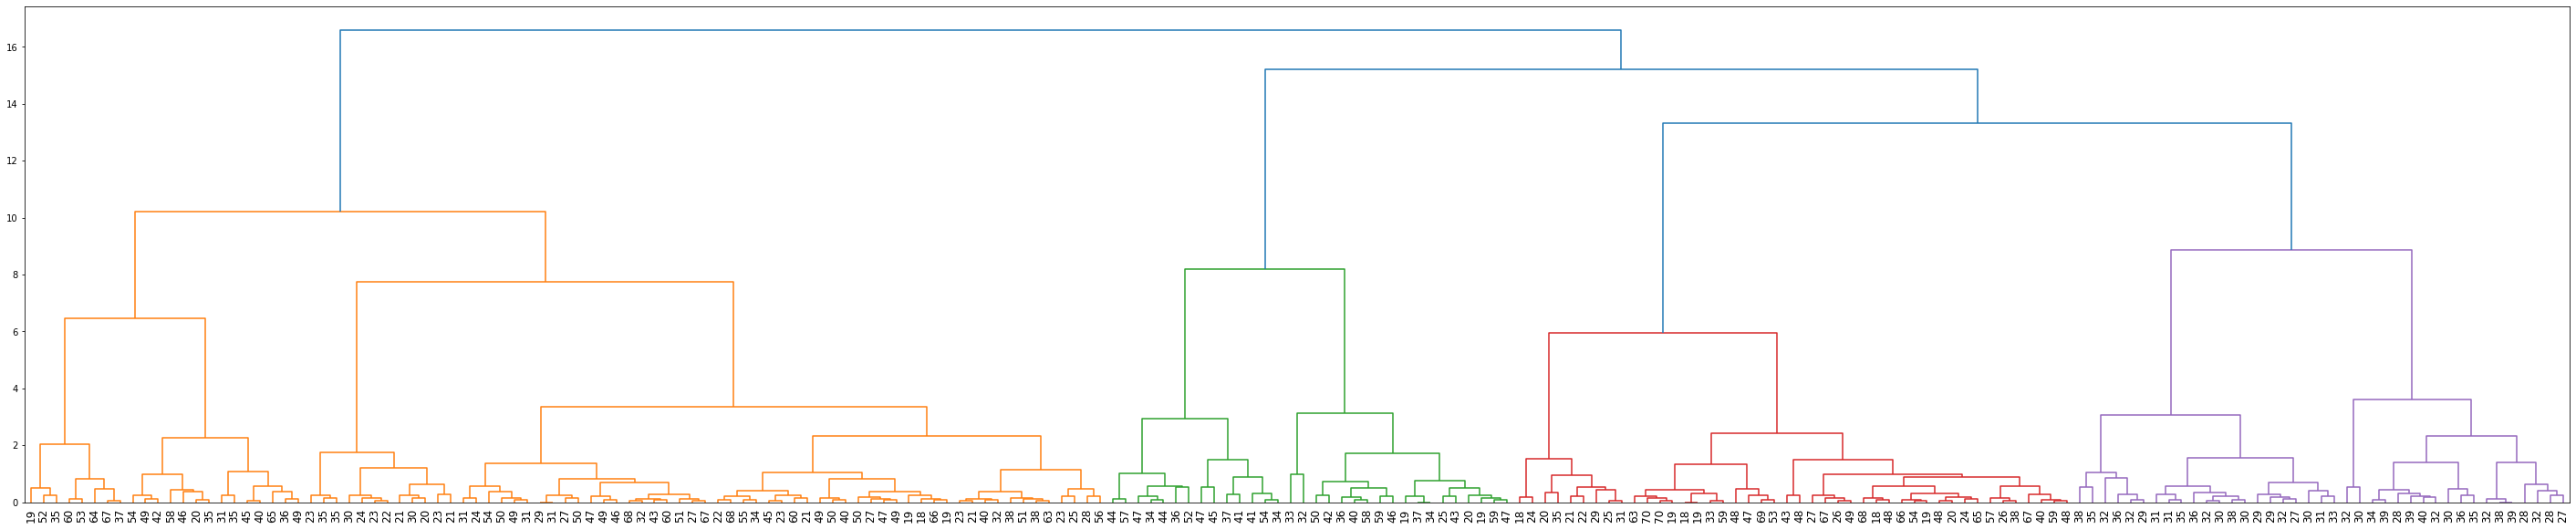

In [7]:
Hier_ward_scaled = hierarchy.linkage(df_scaled, method='ward', metric='euclidean')

fig = plt.figure(figsize=(50, 10))
dn = hierarchy.dendrogram(Hier_ward_scaled,labels=df_scaled.index,leaf_font_size=12)

3. Utiliza un procedimiento, utilizando el índice silueta, para determinar el número óptimo de clústers utilizando la técnica de clústering jerárquico de la librería Sklearn, devolviendo el valor de 'k' óptimo y la asignación de cluster resultante.

In [8]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

def encontrar_k_optimo(df, min_k=2, max_k=20, metric='euclidean', method='ward'):
    mejores_scores = []
    
    # Generar el linkage
    Z = linkage(df, method=method)
    
    for k in range(min_k, max_k+1):
        etiquetas = fcluster(Z, k, criterion='maxclust')
        score = silhouette_score(df, etiquetas, metric=metric)
        mejores_scores.append((k, score))
    
    # Elegir el k con mayor score
    mejor_k, mejor_score = max(mejores_scores, key=lambda x: x[1])
    
    print(f"Número óptimo de clusters: {mejor_k} (silhouette = {mejor_score:.4f})")
    return mejor_k, mejores_scores

k_optimo, scores = encontrar_k_optimo(df, min_k=2)

Número óptimo de clusters: 5 (silhouette = 0.5525)


4. Estima el número de clústeres óptimo mediante la regla del codo en la técnica de Kmeans de Sklearn. ¿Cuál es el número óptimo de clúster? Justifica la respuesta. 

    Ahora utiliza un procedimiento, empleando el índice de Davies-Bouldin, para determinar el número óptimo de clústers en Kmeans de Sklearn. Devuelve el valor de 'k' óptimo y la asignación de cluster resultante.

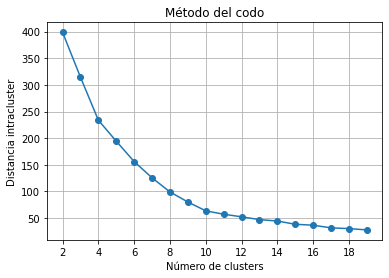

In [9]:
wss = []

for k in range(2, 20):
    clusters_kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    clusters_kmeans.fit(df_scaled)
    wss.append(clusters_kmeans.inertia_)
    
plt.plot(range(2, 20), wss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Distancia intracluster')
plt.title('Método del codo')
plt.xticks(range(2, 20, 2))
plt.grid(True)
plt.show()

Considero que el número óptimo de clusters deberían ser 5 o 6 ya que a partir de ahí la distancia intracluster no disminuye tanto.

In [10]:
clusters_ward = hierarchy.cut_tree(Hier_ward_scaled, n_clusters=k_optimo) # Definimos los 5 clusters que consideramos óptimos anteriormente

metrics.davies_bouldin_score(df_scaled, labels = clusters_ward)

0.9556208250617397

5. Aplica la técnica de clústering DBSCAN, para ello hay que crear el procedimiento para calcular sus parámetros óptimos. Utiliza como medida el índice silueta. Devuelve los parámetros óptimos y la asignación de cluster resultante. ¿Hay algún ejemplo no asignado a algún clúster? Justifica la respuesta. Fija el parámetro `min_samples`, según se indica en los apuntes, a un valor igual a $2*n\_variables -1$.

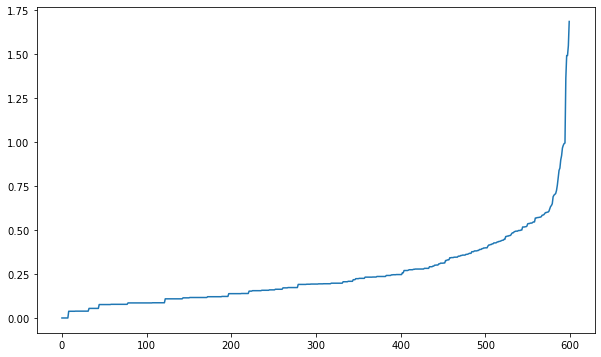

In [11]:
from sklearn.neighbors import NearestNeighbors

# Llamamos a la función NearestNeighbors para calcular la distancia a los 4 vecinos más cercanos.
neighbors = NearestNeighbors(n_neighbors=4).fit(df_scaled)

# Extraemos las distancias y los índices de los vecinos más cercanos con la función kneighbors().
distances, indices = neighbors.kneighbors(df_scaled)

# Elimina la primera columna ya que contiene la distancia de cada punto consigo mismo
distances = distances[:,1:].reshape(-1)

# Transforma la matriz de distancia en una array de dimensión 1.
distances = distances.reshape(-1)

# Ordena las distancias en orden descendente
distances = np.sort(distances, axis=0)

# Crea un gráfico en el que el eje y represente las distancias.
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.show()

Cómo se puede apreciar en el gráfico hay dos cambios de tendencia, uno muy evidente en torno a 0.5 y otro, más suave cercano a 0.1.



In [12]:
# min_samples = 2 * n_variables - 1 = 2 * 3 - 1 = 5

clusters_dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean').fit(df_scaled)

clusters_dbscan.labels_

array([-1,  0,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  0,  1,
        0, -1, -1, -1,  0,  1,  0,  1,  0,  1,  0,  1,  1, -1,  1, -1,  0,
        1,  1,  1,  1,  1,  1,  1, -1,  2,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  2,  1,  2,  1,  2,  1,  2,  2,  2,  1,  1,  2,  2,  1,  1,
        2,  1,  2,  1,  1,  1,  2,  2,  1,  2,  1,  1,  2,  2,  2,  1,  1,
        2,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,  1,  1,  2,  2,  1,  1,
        2,  2,  2,  1,  1,  2,  2,  2,  2,  1,  1,  2,  1,  1,  1,  1,  1,
        1,  2,  1,  1,  3,  1,  4,  2,  3,  5, -1,  5, -1,  1,  4,  5,  4,
        1, -1,  5,  4,  1,  3,  1,  4,  5,  3,  5,  4,  1,  3,  5,  3,  1,
        4,  1,  4,  5,  4,  5,  4,  1,  4,  5,  4,  5,  4,  5,  4,  1, -1,
        5, -1,  5,  3,  1,  4,  5, -1,  5,  3,  1,  4,  5,  4,  1,  3,  1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [14]:
round(metrics.silhouette_score(df_scaled, labels=clusters_dbscan.labels_), 4)

0.3356

Como podemos apreciar, hay varios clusters marcados con la etiqueta `-1`, lo que implica que hay cierto ruido.

6. Compara los resultados de los métodos de los ejercicio 3, 4 y 5. Recuerda analizar y justificar los resultados en función de la medida de la calidad empleada. ¿Qué técnica parece que funciona mejor y por qué?

KMeans ha funcionado relativamente mejor que DBSCAN, viendo que su silueta tiene un valor más cercano a 1.

- `KMeans`: 0.5525
- `DBSCAN`: 0.3356